In [1]:
import os # Useful for running command line within python
import pandas as pd ## Useful for data manipulation

import torch ## Pytorch is the deep learning library that we will be using
import torch.nn as nn # Neural network module

import torchmetrics ## Torchmetrics is a library that contains metrics for evaluating models
from torch.utils.data import DataLoader

from torch.utils.data.dataset import Dataset

import pytorch_lightning as pl 
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torchmetrics.regression import MeanSquaredError
from torchsummary import summary

from torch.nn import ReLU, Sequential
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
def transform_to_range(inputs,historic, y1=1,y0=-1):
    n_inputs=inputs.shape[1]
    names_inputs=historic.columns
    slope=torch.zeros(n_inputs)
    b_array=torch.zeros(n_inputs)
    for i in range(n_inputs):
        x1=historic[names_inputs[i+1]][1]
        x0=historic[names_inputs[i+1]][0]
        slope[i]=(y1-y0)/(x1-x0)
        b_array[i]=-x0*slope[i]+y0
                    
    return inputs*slope+b_array

def create_array_from_steps(tensor,step):
    l,n=tensor.shape
    new_tensor=torch.zeros((l-step+1,step,n))
    for i in range(l-step+1):
        new_tensor[i]=tensor[i:i+step]
        
    return new_tensor

Construct the training, validation and test set

In [3]:
## We are creating a custom dataset class
class WeatherData(Dataset):

    def __init__(self, csv_inputs, csv_outputs,csv_historic,step,pred_time=24,y1=1,y0=-1):
        """
        Arguments:
            csv_inputs (string): Path to the csv file of the inputs of the NN.
            csv_outputs (string): Path to the csv file of temperatures 24 and 48 hours after measurement .
            csv_historic (string): Path to the csv file of historic weather data.
            step (int): The number of measurements that the model will look to make a prediction.
            pred_time (int): 24 or 48. Indicates that the prediction will be time 24 or 48 hours later.
        """
        
        input_data = pd.read_csv(csv_inputs)
        output_data= pd.read_csv(csv_outputs)
        output_data=output_data["temperature_{}".format(pred_time)]
        historic= pd.read_csv(csv_historic)
        
        
        ## Transform input data
        n=len(input_data)
        minutes=[datetime.datetime.strptime(input_data["local_time"][i], '%Y-%m-%d %H:%M:%S').minute for i in range(n)]
        input_data["local_time"]=minutes
        inputs_tmp=transform_to_range(torch.tensor(input_data.values.astype(np.float32)),historic,y1=y1,y0=y0)
        self.inputs=create_array_from_steps(inputs_tmp,step)
        
        #Transform output data
        x1_temperature=historic["Air_Temperature_in_degrees_C"][1]
        x0_temperature=historic["Air_Temperature_in_degrees_C"][0]
        slope_temperature=(y1-y0)/(x1_temperature-x0_temperature)
        b_temperature=-x0_temperature*slope_temperature+y0
        outputs_tmp=torch.tensor(output_data.values.astype(np.float32))*slope_temperature+b_temperature
        self.outputs=outputs_tmp[step-1:]
        
    
        
        

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx:int):
        return self.inputs[idx],self.outputs[idx]

In [4]:
input_86077="./data/cleaned_data/86077_aws_plumber_data_inputs.csv"
output_86077="./data/cleaned_data/86077_aws_plumber_data_outputs.csv"
historic_path="./data/cleaned_data/Historical_data.csv"

In [9]:
dataset=WeatherData(input_86077,output_86077,historic_path,10,pred_time=48)

In [10]:
dataset.inputs.shape

torch.Size([87465, 10, 11])

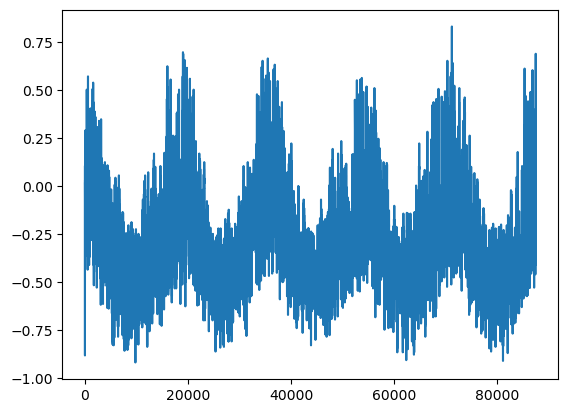

In [11]:
plt.plot(np.array(dataset[:][1]))

The data is order chronologically, so the division in terms of training, validation, and test should not be random. Instead, the data will be partition in 3 blocks. The blocks are ordered in chronological order. 

In [12]:
n_data=len(dataset)
split=[0.8,0.1,0.1]
n_train=int(np.floor(split[0]*n_data))
n_val=int(np.floor(split[1]*n_data))

trainset=torch.utils.data.Subset(dataset, range(n_train))
valset=torch.utils.data.Subset(dataset, range(n_train,n_train+n_val))
testset =torch.utils.data.Subset(dataset, range(n_train,n_data))

In [13]:
# Define a batch 
BATCH_SIZE = 256 #Just indicate the batch size

# Create Dataloaders 
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE )
valloader = DataLoader(valset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

I need to correct the WeatherLSTM class. Now the dataset have several time steps saved.

In [19]:
## We are going to use the PyTorch's nn.LSTM() method
class WeatherLSTM(pl.LightningModule):

    def __init__(self, n, learning_rate=1e-2, traindataloader=None, valdataloader=None, testdataloader=None): 
        
        super().__init__() # initialize an instance of the parent class, LightningModule.

        self.n=n
        self.lstm = nn.LSTM(input_size=self.n, hidden_size=1, batch_first=True) 
        ## The input size corresponds to the number of features of each measurement
        ## The hidden size gives the size of the output. In our case 2. The 24 and 48 temperature prediction
        
        # define learning rate
        self.learning_rate = learning_rate ## Just the numerical value of the learning rate

        # define loss function (Huber loss). This function is robust against outliers
        self.loss_fun = nn.HuberLoss() ## The function to calculate the loss
        
        # We calculate the mean square error as a perfomance metric
        
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()
        
         # Define dataloaders
        self.traindataloader = traindataloader ### I am just passing the corresponding dataloader
        self.valdataloader = valdataloader   ### I am just passing the corresponding dataloader
        self.testdataloader = testdataloader ### I am just passing the corresponding dataloader
         

    def forward(self, x):
        bs=x.shape[0] ## Extract the size of the batch
        
        #x=x.view(len(x), self.n)
        #x=torch.unsqueeze(x,0)
        lstm_out, _ = self.lstm(x)
        
        ## lstm_out has the short-term memories for all inputs. We make our prediction with the last one
        ## It gives you the output of every hidden cell. But we only the last prediction
        prediction=lstm_out[:,-1,:]
        
        
        #prediction = lstm_out[-1] 
        return prediction.reshape(len(prediction))  #This will give a prediction of the size of the temperatures
    
    def training_step(self, batch, batch_idx):

        # Make predictions
        x,y=batch ## The batch should come from the CovidDataset class
        # Do the prediction
        
        y_hat=self.forward(x) ## This predicts the results from x

        # Calculate the loss
        # Apply the loss function here
        loss=self.loss_fun(y_hat,y) ## Calculate the loss with the function declared in this class
        ## Update the MSE
        self.train_mse.update(y_hat, y)
        
        
        # Record accuracy and loss
        # Calling self.log will surface up scalars for you in TensorBoard
        # You may add more logs as you think necessary
         
        ### In the next two lines the history of the loss and accuracy is logged
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_mse", self.train_mse, prog_bar=True, on_step=False, on_epoch=True)

        # Return the loss
        return loss ## 

    def validation_step(self, batch, batch_idx):
        
        ### I am going to reuse the code for the training
        x,y=batch 
        y_hat=self.forward(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 
        ## Update the MSE
        self.val_mse.update(y_hat, y)


        # Record accuracy and loss
        # Log anything you think necessary
        ### Save the logs for the loss and for the accuracy
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_mse", self.val_mse, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        
        x,y=batch 
        y_hat=self.forward(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 

        self.test_mse.update(y_hat, y) 

        # Record accuracy and loss
        # Log anything you think necessary
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_mse", self.test_mse, prog_bar=True, on_step=False, on_epoch=True)

    def predict_step(self, batch, batch_idx):
        
        x,y=batch
        # Do prediction
        y_hat=self.forward(x)

        return y_hat,y,x # Return prediction, actual value and inputs  
        
        
    def configure_optimizers(self): 
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) 

    
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        # return the train dataloader
        return  self.traindataloader ## Just return the traindataloader

    def val_dataloader(self):
        # return the validation dataloader
        return self.valdataloader  ### Just return the valdataloader

    def test_dataloader(self):
        # return the test dataloader
        return self.testdataloader  ## Just return the testdataloader

In [11]:
# Initialize the model by creating instance from Model class
lstm_model = WeatherLSTM(11, traindataloader=trainloader, valdataloader=valloader, testdataloader=testloader)


In [12]:

lstm_callback = ModelCheckpoint(
        monitor='val_mse',
        dirpath='.\\logs_lstm',
        save_top_k=1,
        mode='min',
        every_n_epochs=1)
# Monitor the validation mean square eror
# Specify a directory for checkpoints
# save the one best model
# Save the min. monitored quantity
# Monitor every 1 epoch


# Create a Trainer
n_epochs=100  ## I am defining the maximum number of epochs
lstm_trainer = pl.Trainer(accelerator = "auto",
                  max_epochs = n_epochs,
                  callbacks = [TQDMProgressBar(refresh_rate=20),lstm_callback],
                  logger = CSVLogger(save_dir=".\\logs_lstm"))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
#Uncomment to further train
#lstm_trainer.fit(lstm_model)

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\logs_lstm exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
## Load the model

In [14]:
checkpoint_86077= torch.load('.\\logs_lstm\epoch=99-step=27400.ckpt') 
state_dict_86077 = checkpoint_86077['state_dict']
lstm_model.load_state_dict(state_dict_86077)

<All keys matched successfully>

In [17]:
#lstm_metrics =  pd.read_csv(lstm_trainer.logger.log_dir +"/metrics.csv") ###
lstm_metrics =  pd.read_csv(".\\logs_lstm\\lightning_logs\\version_0/metrics.csv") ###

lstm_metrics.set_index("epoch", inplace=True) ## Set the column epoch as the index of the DataFrame
lstm_metrics = lstm_metrics.groupby(level=0).sum()  ##It groups by epoch by summing the rows with the same epoch
## The previous line also make the NaN values disappear, as those are not considered in a sum.
lstm_metrics=lstm_metrics.drop("step", axis=1) # The column step lose its meaning while adding

Text(0, 0.5, 'Loss')

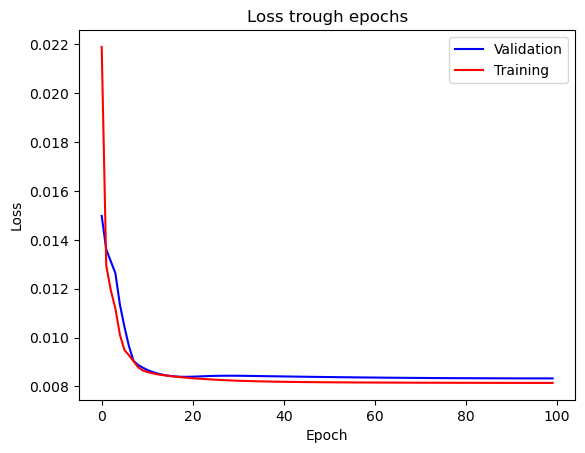

In [18]:
plt.plot(lstm_metrics["val_loss"][:-1],'b-', label="Validation")
plt.plot(lstm_metrics["train_loss"][:-1],'r-', label="Training")
plt.legend()
plt.title("Loss trough epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'MSE')

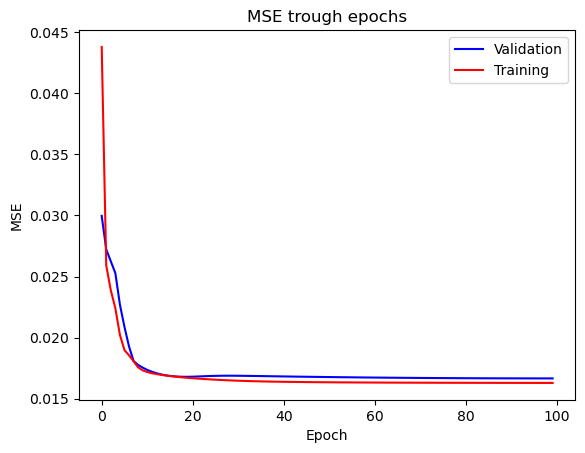

In [19]:
plt.plot(lstm_metrics["val_mse"][:-1],'b-', label="Validation")
plt.plot(lstm_metrics["train_mse"][:-1],'r-', label="Training")
plt.legend()
plt.title("MSE trough epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Test MSE

In [20]:
lstm_trainer.test(lstm_model)

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.008790599182248116    │
│         test_mse          │    0.01758119836449623    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.008790599182248116, 'test_mse': 0.01758119836449623}]

# Test the predictions

I first need a function to unnormalize the data

In [21]:
n_test=len(testset)
prediction_test=np.zeros(n_test)
lstm_model.eval() ##Put the model in evaluation mode.

with torch.no_grad():
    for i in range(n_test):
        prediction_test[i]=float(lstm_model(torch.unsqueeze(testset[i][0],0)))
    

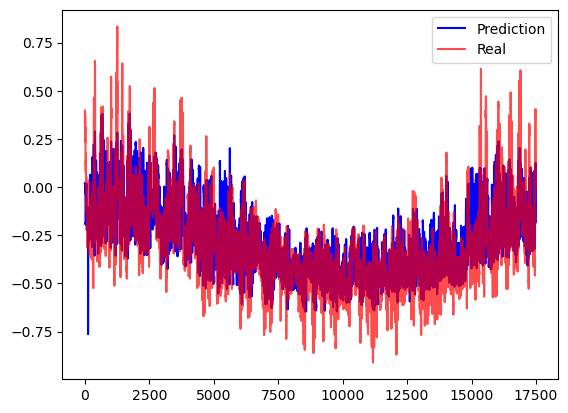

In [22]:
plt.plot(prediction_test,"b-",label="Prediction")
plt.plot(np.array(testset[:][1]),"r-",label="Real", alpha=0.7)
plt.legend()

In [14]:
def unnormalize_data(prediction,historic_path, x1=1,x0=-1):
    
    historic= pd.read_csv(historic_path)
    names_inputs=historic.columns
    y1=historic["Air_Temperature_in_degrees_C"][1]
    y0=historic["Air_Temperature_in_degrees_C"][0]
    slope=(y1-y0)/(x1-x0)
    b=-x0*slope+y0
                    
    return prediction*slope+b

In [24]:
unnormalized_pred=unnormalize_data(prediction_test,historic_path)
unnormalized_data=unnormalize_data(np.array(testset[:][1]),historic_path)

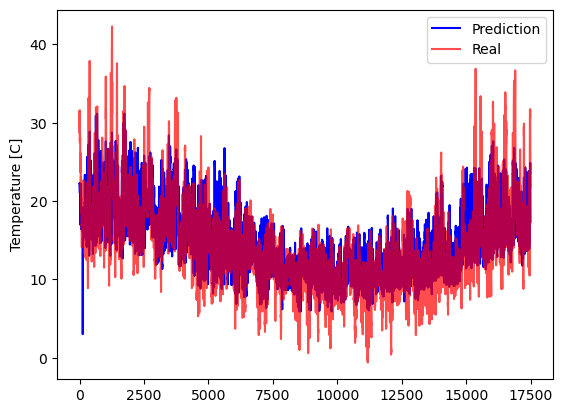

In [25]:
plt.plot(unnormalized_pred,"b-",label="Prediction")
plt.plot(unnormalized_data,"r-",label="Real", alpha=0.7)
plt.ylabel("Temperature [C]")
plt.legend()

In [26]:
prediction_86077=pd.DataFrame({"Measured":unnormalized_data,"Prediction":unnormalized_pred})
prediction_86077.to_csv(".\predictions\lstm_predictions_86077.csv", index=False)
np.sum((unnormalized_data-unnormalized_pred)**2)/len(unnormalized_data)

In [29]:
np.sum((unnormalized_data-unnormalized_pred)**2)/len(unnormalized_data)

10.63943957897434

# Make predictions for all the bases

In [16]:
aws_locations = {
    'Melbourne Airport': {'station_id':"86282", },
    'Moorabbin Airport': {'station_id':"86077", },
    'Laverton RAAF': {'station_id':"87031", },
}


input_data_dir = './data/cleaned_data/'

Starting with 86282 at prediction time 24


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\pred_logs_lstm\86282_pred24 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


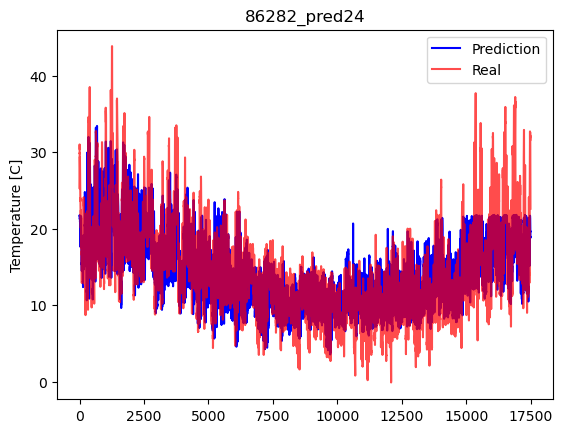

The MSE is 11.784848049256974
Starting with 86282 at prediction time 48


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\pred_logs_lstm\86282_pred48 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


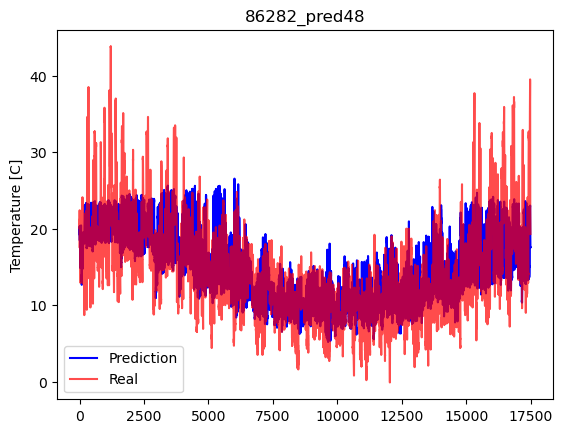

The MSE is 14.482823206854956
Starting with 86077 at prediction time 24


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\pred_logs_lstm\86077_pred24 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


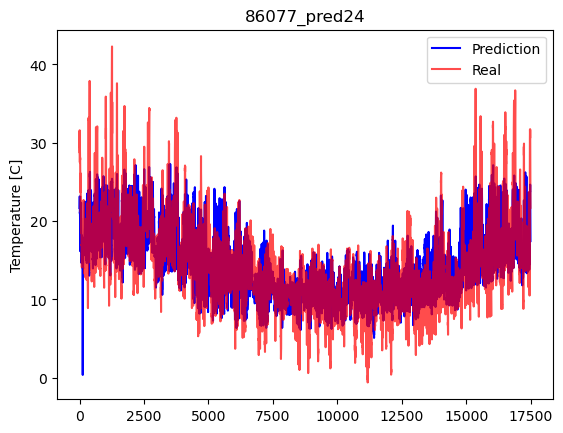

The MSE is 10.926939914555422
Starting with 86077 at prediction time 48


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\pred_logs_lstm\86077_pred48 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


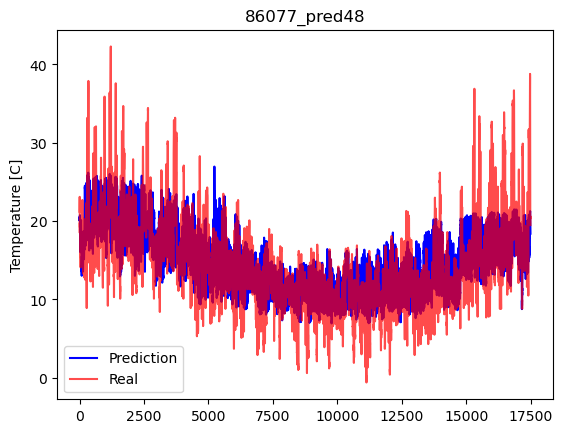

The MSE is 13.325910381178915
Starting with 87031 at prediction time 24


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\pred_logs_lstm\87031_pred24 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


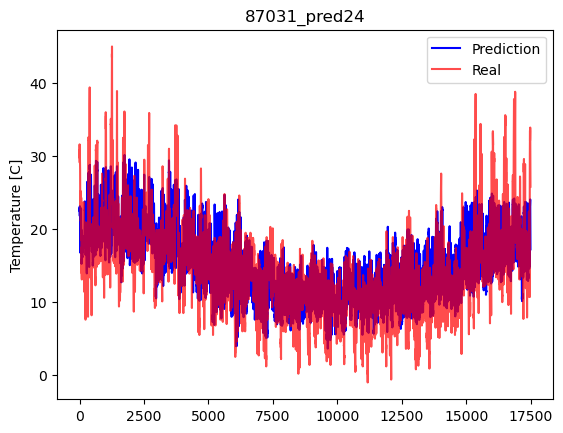

The MSE is 12.01800321593426
Starting with 87031 at prediction time 48


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\pred_logs_lstm\87031_pred48 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


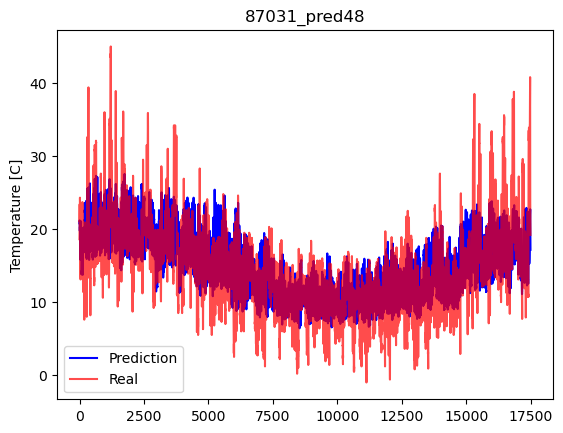

The MSE is 13.483881287251949


In [21]:
for loc in aws_locations:
    station_id = aws_locations[loc]['station_id']
    
    file_path_input=input_data_dir+station_id+"_aws_plumber_data_inputs.csv"
    file_path_output=input_data_dir+station_id+"_aws_plumber_data_outputs.csv"
    
    for j in [24,48]:
        # Prepare datasets
        print("Starting with {} at prediction time {}".format(station_id,j))
        dataset=WeatherData(file_path_input,file_path_output,historic_path,10,pred_time=j)

        n_data=len(dataset)
        split=[0.8,0.1,0.1]
        n_train=int(np.floor(split[0]*n_data))
        n_val=int(np.floor(split[1]*n_data))

        trainset=torch.utils.data.Subset(dataset, range(n_train))
        valset=torch.utils.data.Subset(dataset, range(n_train,n_train+n_val))
        testset =torch.utils.data.Subset(dataset, range(n_train,n_data))

        # Create Dataloaders 
        trainloader = DataLoader(trainset, batch_size=BATCH_SIZE )
        valloader = DataLoader(valset, batch_size=BATCH_SIZE)
        testloader = DataLoader(testset, batch_size=BATCH_SIZE)
        
        lstm_model = WeatherLSTM(11, traindataloader=trainloader, valdataloader=valloader, testdataloader=testloader)
        
        ## Save the results in different folders
        lstm_callback = ModelCheckpoint(
                monitor='val_mse',
                dirpath='.\pred_logs_lstm\{}_pred{}'.format(station_id,j),
                save_top_k=1,
                mode='min',
                every_n_epochs=1)
        # Monitor the validation mean square eror
        # Specify a directory for checkpoints
        # save the one best model
        # Save the min. monitored quantity
        # Monitor every 1 epoch


        # Create a Trainer
        n_epochs=100  ## I am defining the maximum number of epochs
        lstm_trainer = pl.Trainer(accelerator = "auto",
                          max_epochs = n_epochs,
                          callbacks = [TQDMProgressBar(refresh_rate=20),lstm_callback],
                          logger = CSVLogger(save_dir='.\pred_logs_lstm\{}_pred{}'.format(station_id,j)))
        
        # Train the model
        lstm_trainer.fit(lstm_model)
        
        # Evaluate the model
        n_test=len(testset)
        prediction_test=np.zeros(n_test)
        lstm_model.eval() ##Put the model in evaluation mode.

        with torch.no_grad():
            for i in range(n_test):
                prediction_test[i]=float(lstm_model(torch.unsqueeze(testset[i][0],0)))
                
        # Unnormalize the data
        unnormalized_pred=unnormalize_data(prediction_test,historic_path)
        unnormalized_data=unnormalize_data(np.array(testset[:][1]),historic_path)
        
        # Plot the result to detect any anomaly
        plt.plot(unnormalized_pred,"b-",label="Prediction")
        plt.plot(unnormalized_data,"r-",label="Real", alpha=0.7)
        plt.ylabel("Temperature [C]")
        plt.title("{}_pred{}".format(station_id,j))
        plt.legend()
        plt.show()
        
        # Save the results
        prediction_station=pd.DataFrame({"Measured":unnormalized_data,"Prediction":unnormalized_pred})
        prediction_station.to_csv(".\predictions\lstm_predictions_{}_pred{}.csv".format(station_id,j), index=False)
        mse_final=np.sum((unnormalized_data-unnormalized_pred)**2)/len(unnormalized_data)
        print("The MSE is {}".format(mse_final))